In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

### Load data

In [2]:
df = pd.read_table('data/pearson-lee-sons.txt')
x_raw = df.Father.to_numpy()
y_raw = df.Son.to_numpy()

In [3]:
x_raw.std(ddof=1) * 2.54

6.9719657691281345

In [4]:
y_raw.std(ddof=1) * 2.54

7.149342046186907

Karl Pearson organized the collection of data on over 1100 families in England in the period 1893 to 1898. This particular data set gives the Heights in inches of mothers and their daughters, with up to two daughters per mother. All daughters are at least age 18, and all mothers are younger than 65. Data were given in the source as a frequency table to the nearest inch. Rounding error has been added to remove discreteness from graph.



In [5]:
print(x_raw.size)

1078


### Standardize

In [6]:
x_sample_sd = x_raw.std(ddof=1)
x_sample_mean = x_raw.mean()

In [7]:
x = (x_raw - x_sample_mean) / x_sample_sd
y = (y_raw - x_sample_mean) / x_sample_sd

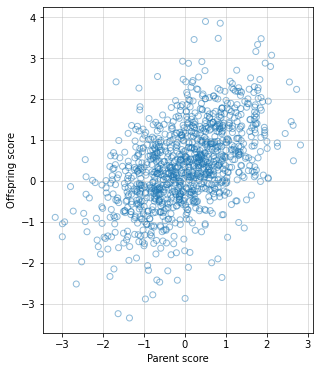

In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.5,
           facecolors='none', edgecolors='#1f77b4')
plt.grid(alpha=0.5)
plt.xlabel('Parent score')
plt.ylabel('Offspring score')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Linear Model Verification

### 1. Check normality of $X_0$

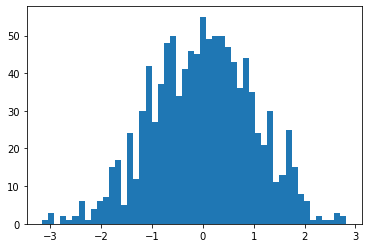

In [9]:
plt.hist(x, bins=50);

In [10]:
def normal_qq(data):
    n = data.size
    theor = data.std() * stats.norm.ppf(
        np.arange(1, n + 1) / (n + 1)) + data.mean()
    return theor, np.sort(data)    

def plt_normal_qq(data, lim=3.5):
    x_theor, x_sample = normal_qq(data)
    
    plt.plot([-5, 5], [-5, 5], color='grey')
    plt.scatter(x_theor, x_sample, alpha=0.6, 
                facecolors='none', edgecolors='#1f77b4')
    plt.xlim([-lim, lim])
    plt.ylim([-lim, lim])
    plt.grid(alpha=0.3)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('Theoretical')
    plt.ylabel('Observed')

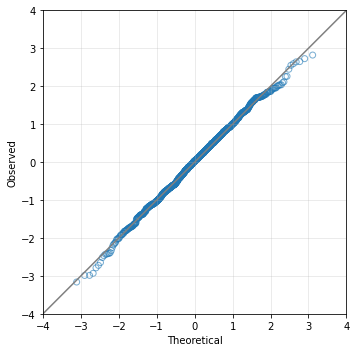

In [11]:
plt.figure(figsize=(5, 5))
plt_normal_qq(x, lim=4)
plt.tight_layout()
# plt.savefig('latex/figures/qq_pearson_x-sons.png', dpi=300)

In [12]:
print(np.round(stats.skew(x), 5))
print(np.round(stats.kurtosis(x), 5))

-0.08815
-0.16035


#### Tests of normality for skew and kurtosis

In [13]:
stats.skewtest(x)

SkewtestResult(statistic=-1.1873296087790632, pvalue=0.2350976334423146)

In [14]:
stats.kurtosistest(x)

KurtosistestResult(statistic=-1.0683781547409283, pvalue=0.28534996696925896)

In [15]:
stats.normaltest(x)

NormaltestResult(statistic=2.5511834814110745, pvalue=0.2792656664558382)

### 2. Estimate $r$ and $rs$

In [16]:
from sklearn.linear_model import LinearRegression

lmb = LinearRegression(fit_intercept=True)
lmb.fit(x.reshape(-1, 1), y)

LinearRegression()

In [17]:
print('Using SkLearn software:', lmb.intercept_, lmb.coef_)

Using SkLearn software: 0.3632133283586762 [0.51409304]


In [18]:
r = lmb.coef_[0]
c = lmb.intercept_

In [19]:
# Manually
X = np.concatenate([[np.ones(x.size)], [x]]).T

Y = y.reshape(-1, 1)

B = np.linalg.inv(X.T @ X) @ X.T @ Y
assert B.shape[0] == 2
B

array([[0.36321333],
       [0.51409304]])

In [20]:
epsi = y - r*x - c

In [21]:
rs = np.sqrt(np.dot(epsi, epsi) / (epsi.size - 2))

In [22]:
# estimate of c in centimeters
c * x_sample_sd * 2.54

2.5323108922077875

In [23]:
print(np.round(r, 5))
print(np.round(rs, 5))

0.51409
0.88768


### 3. Verify normality of the residuals

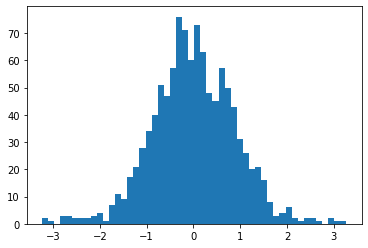

In [24]:
plt.hist(epsi, bins=50);

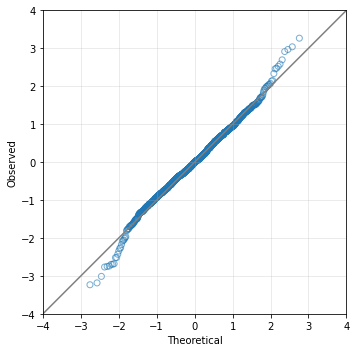

In [25]:
plt.figure(figsize=(5, 5))
plt_normal_qq(epsi, lim=4)
plt.tight_layout()
# plt.savefig('latex/figures/qq_pearson_epsi-sons.png', dpi=300)

In [26]:
print(np.round(stats.skew(epsi), 5))

-0.05127


In [27]:
print(np.round(stats.kurtosis(epsi), 5))

0.82237


#### Tests of normality for skew and kurtosis

In [28]:
stats.skewtest(epsi)

SkewtestResult(statistic=-0.6914315216916934, pvalue=0.48929440063613416)

In [29]:
stats.kurtosistest(epsi)

KurtosistestResult(statistic=4.138445316508387, pvalue=3.496671880723241e-05)

In [30]:
stats.normaltest(epsi)

NormaltestResult(statistic=17.6048071869191, pvalue=0.00015037120912559472)

### Check if the residual varies with the parent score

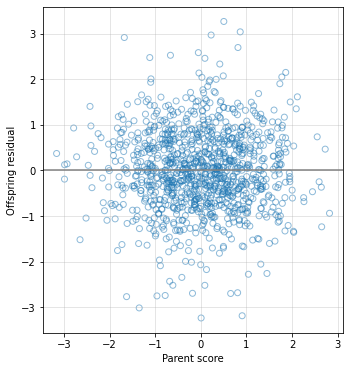

In [31]:
plt.figure(figsize=(6, 6))
plt.scatter(x, epsi, alpha=0.5,
           facecolors='none', edgecolors='#1f77b4')
plt.axhline(y=0, color='grey')
plt.grid(alpha=0.4)
plt.xlabel('Parent score')
plt.ylabel('Offspring residual')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [32]:
bins = np.arange(-2, 2.5, 0.5)

In [33]:
x_binned = np.digitize(x, bins)

In [34]:
epsi_means = np.array([epsi[x_binned == i].mean() - epsi.mean() for i in range(bins.size+1)])

epsi_sds = np.array([epsi[x_binned == i].std() for i in range(bins.size+1)])


In [35]:
true_bins = np.arange(-2.25, 2.75, 0.5)

#### SD confidence interval

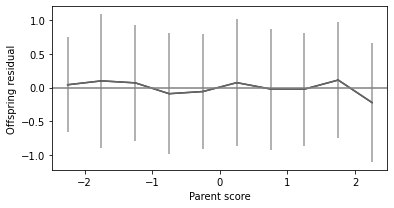

In [36]:
plt.figure(figsize=(6, 6))
plt.plot(true_bins, epsi_means, color='black')
plt.errorbar(true_bins, epsi_means,
            yerr=epsi_sds, color='grey', alpha=0.8)
# plt.ylim(-0.3, 0.3)
plt.axhline(y=0, color='grey')
# plt.grid(alpha=0.4)
plt.xlabel('Parent score')
plt.ylabel('Offspring residual')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Normal confidence interval

In [37]:
epsi_cis = np.array([stats.norm.interval(alpha=0.95, 
                        loc=np.mean(epsi[x_binned == i] - epsi.mean()), 
                    scale=stats.sem(epsi[x_binned == i] - epsi.mean())) 
                     for i in range(bins.size+1)])

epsi_cis = np.abs(epsi_cis - epsi_means.reshape(-1, 1))

In [38]:
epsi_means

array([ 0.0416266 ,  0.09919112,  0.06962963, -0.09056727, -0.05854507,
        0.07287641, -0.02128133, -0.02316499,  0.11114314, -0.2217388 ])

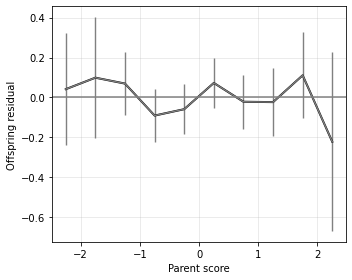

In [39]:
plt.figure(figsize=(5, 4))
plt.plot(true_bins, epsi_means, color='black', linewidth=2)
plt.errorbar(true_bins, epsi_means,
            yerr=epsi_cis.T, color='grey', alpha=1, linewidth=1.4)
# plt.ylim(-0.3, 0.3)
plt.axhline(y=0, color='grey')
plt.grid(alpha=0.3)
plt.xlabel('Parent score')
plt.ylabel('Offspring residual')
# plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
# plt.savefig('latex/figures/pearson_residuals_by_score-sons.png', dpi=300)
plt.show()

### Population variance dynamics

In [40]:
r, rs

(0.514093038623308, 0.8876767206912776)

In [41]:
r**2 + rs**2

1.0522616128181665

In [42]:
y.var(ddof=1)

1.0515299786858936

In [57]:
np.sqrt(r**2 + rs**2)

1.0257980370512347

In [43]:
print(y.std(ddof=1))
print(x.std(ddof=1))

1.025441357994641
1.0


#### The offspring heights are indeed normal

In [44]:
stats.skewtest(y)

SkewtestResult(statistic=-0.49438644166130596, pvalue=0.6210332874918335)

In [45]:
stats.kurtosistest(y)

KurtosistestResult(statistic=2.9813610649654287, pvalue=0.0028697022712870454)

In [46]:
stats.normaltest(y)

NormaltestResult(statistic=9.132931753390324, pvalue=0.010394630786312996)

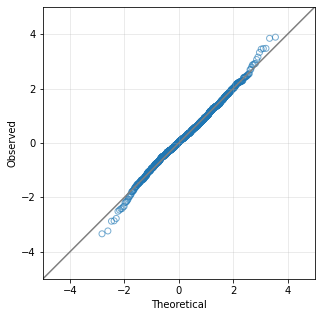

In [47]:
plt.figure(figsize=(5, 5))
plt_normal_qq(y, lim=5)

#### Test for equality of variances

In [48]:
stats.levene(x, y, center='mean')

LeveneResult(statistic=0.10692246285726498, pvalue=0.7437072172197279)

In [49]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1 - stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p


In [50]:
f_test(y, x)

(1.0515299786858936, 0.20489946038016027)

### Miscellaneous

In [51]:
stats.ttest_ind(x, y, equal_var=False)

Ttest_indResult(statistic=-8.325919805445945, pvalue=1.4680170030149303e-16)

In [52]:
stats.ttest_ind(x, y - c, equal_var=False)

Ttest_indResult(statistic=-1.6922320348786633e-14, pvalue=0.9999999999999865)

In [53]:
stats.ttest_1samp(epsi, 0)

Ttest_1sampResult(statistic=-1.4634536058878098e-15, pvalue=0.9999999999999989)

In [54]:
y.var()

1.0505545334366488

In [55]:
epsi.mean()

-3.954783315918925e-17

In [56]:
np.cov(x, y) 

array([[1.        , 0.51409304],
       [0.51409304, 1.05152998]])